# Optimal Savings I: Value Function Iteration

```{include} _admonition/gpu.md
```

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

We will use the following imports:

In [2]:
import quantecon as qe
import numpy as np
import jax
import jax.numpy as jnp
from collections import namedtuple
import matplotlib.pyplot as plt
import time

Let's check the GPU we are running

In [3]:
!nvidia-smi

/opt/conda/envs/quantecon/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Thu Mar 14 02:15:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   26C    P0    36W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


We'll use 64 bit floats to gain extra precision.

In [4]:
jax.config.update("jax_enable_x64", True)

## Overview

We consider an optimal savings problem with CRRA utility and budget constraint

$$ 
W_{t+1} + C_t \leq R W_t + Y_t 
$$

We assume that labor income $(Y_t)$ is a discretized AR(1) process.

The right-hand side of the Bellman equation is

$$   
B((w, y), w', v) = u(Rw + y - w') + β \sum_{y'} v(w', y') Q(y, y'). 
$$

where

$$
u(c) = \frac{c^{1-\gamma}}{1-\gamma} 
$$

## Starting with NumPy

Let's start with a standard NumPy version, running on the CPU.

This is a traditional approach using relatively old technologies.

One reason we start with NumPy is that switching from NumPy to JAX will be
relatively trivial.

The other reason is that we want to know the speed gain associated with
switching to JAX.

(NumPy operations are similar to MATLAB operations, so this also serves as a
rough comparison with MATLAB.)

### Functions and operators

The following function contains default parameters and returns tuples that
contain the key computational components of the model.

In [5]:
def create_consumption_model(R=1.01,                    # Gross interest rate
                             β=0.98,                    # Discount factor
                             γ=2,                       # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5.0,                 # Max wealth
                             w_size=150,                # Grid side
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns parameters and grids 
    for the optimal savings problem.
    """
    w_grid = np.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = np.exp(mc.state_values), mc.P
    w_grid, y_grid, Q = tuple(map(jax.device_put, [w_grid, y_grid, Q]))
    sizes = w_size, y_size
    return (β, R, γ), sizes, (w_grid, y_grid, Q)

(The function returns sizes of arrays because we use them later to help
compile functions in JAX.)

To produce efficient NumPy code, we will use a vectorized approach. 

The first step is to create the right hand side of the Bellman equation as a
multi-dimensional array with dimensions over all states and controls.

In [6]:
def B(v, constants, sizes, arrays):
    """
    A vectorized version of the right-hand side of the Bellman equation
    (before maximization), which is a 3D array representing

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    for all (w, y, w′).
    """

    # Unpack
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Compute current rewards r(w, y, wp) as array r[i, j, ip]
    w  = np.reshape(w_grid, (w_size, 1, 1))    # w[i]   ->  w[i, j, ip]
    y  = np.reshape(y_grid, (1, y_size, 1))    # z[j]   ->  z[i, j, ip]
    wp = np.reshape(w_grid, (1, 1, w_size))    # wp[ip] -> wp[i, j, ip]
    c = R * w + y - wp

    # Calculate continuation rewards at all combinations of (w, y, wp)
    v = np.reshape(v, (1, 1, w_size, y_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = np.reshape(Q, (1, y_size, 1, y_size))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = np.sum(v * Q, axis=3)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return np.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -np.inf)

Here are two functions we need for value function iteration.

The first is the Bellman operator.

The second computes a $v$-greedy policy given $v$ (i.e., the policy that
maximizes the right-hand side of the Bellman equation.)

In [7]:
def T(v, constants, sizes, arrays):
    "The Bellman operator."
    return np.max(B(v, constants, sizes, arrays), axis=2)

def get_greedy(v, constants, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return np.argmax(B(v, constants, sizes, arrays), axis=2)

### Value function iteration

Here's a routine that performs value function iteration.

In [8]:
def vfi(model, max_iter=10_000, tol=1e-5):
    constants, sizes, arrays = model
    v = np.zeros(sizes)
    i, error = 0, tol + 1
    while error > tol and i < max_iter:
        v_new = T(v, constants, sizes, arrays)
        error = np.max(np.abs(v_new - v))
        i += 1
        v = v_new
    return v, get_greedy(v, constants, sizes, arrays)

Now we create an instance, unpack it, and test how long it takes to solve the
model.

In [9]:
model = create_consumption_model()
# Unpack
constants, sizes, arrays = model
β, R, γ = constants
w_size, y_size = sizes
w_grid, y_grid, Q = arrays

print("Starting VFI.")
start_time = time.time()
v_star, σ_star = vfi(model)
numpy_elapsed = time.time() - start_time
print(f"VFI completed in {numpy_elapsed} seconds.")

Starting VFI.


VFI completed in 15.820155382156372 seconds.


Here's a plot of the policy function.

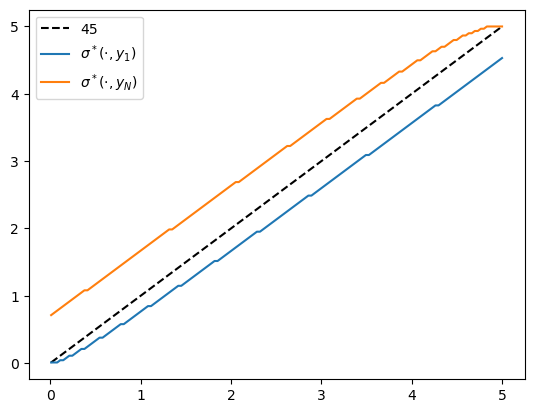

In [10]:
fig, ax = plt.subplots()
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star[:, 1]], label="$\\sigma^*(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star[:, -1]], label="$\\sigma^*(\cdot, y_N)$")
ax.legend()
plt.show()

## Switching to JAX

To switch over to JAX, we change `np` to `jnp` throughout and add some
`jax.jit` requests.


### Functions and operators

We redefine `create_consumption_model` to produce JAX arrays.

(prgm:create-consumption-model)=

In [11]:
def create_consumption_model(R=1.01,                    # Gross interest rate
                             β=0.98,                    # Discount factor
                             γ=2,                       # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5.0,                 # Max wealth
                             w_size=150,                # Grid side
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns parameters and grids 
    for the optimal savings problem.
    """
    w_grid = jnp.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = jnp.exp(mc.state_values), jax.device_put(mc.P)
    sizes = w_size, y_size
    return (β, R, γ), sizes, (w_grid, y_grid, Q)

The right hand side of the Bellman equation is the same as the NumPy version
after switching `np` to `jnp`.

In [12]:
def B(v, constants, sizes, arrays):
    """
    A vectorized version of the right-hand side of the Bellman equation
    (before maximization), which is a 3D array representing

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    for all (w, y, w′).
    """

    # Unpack
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Compute current rewards r(w, y, wp) as array r[i, j, ip]
    w  = jnp.reshape(w_grid, (w_size, 1, 1))    # w[i]   ->  w[i, j, ip]
    y  = jnp.reshape(y_grid, (1, y_size, 1))    # z[j]   ->  z[i, j, ip]
    wp = jnp.reshape(w_grid, (1, 1, w_size))    # wp[ip] -> wp[i, j, ip]
    c = R * w + y - wp

    # Calculate continuation rewards at all combinations of (w, y, wp)
    v = jnp.reshape(v, (1, 1, w_size, y_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = jnp.reshape(Q, (1, y_size, 1, y_size))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = jnp.sum(v * Q, axis=3)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -jnp.inf)


B = jax.jit(B, static_argnums=(2,))

Some readers might be concerned that we are creating high dimensional arrays,
leading to inefficiency.

Could they be avoided by more careful vectorization?

In fact this is not necessary: this function will be JIT-compiled by JAX, and
the JIT compiler will optimize compiled code to minimize memory use.


The Bellman operator $T$ can be implemented by

In [13]:
def T(v, constants, sizes, arrays):
    "The Bellman operator."
    return jnp.max(B(v, constants, sizes, arrays), axis=2)

T = jax.jit(T, static_argnums=(2,))

The next function computes a $v$-greedy policy given $v$ (i.e., the policy that
maximizes the right-hand side of the Bellman equation.)

In [14]:
def get_greedy(v, constants, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, constants, sizes, arrays), axis=2)

get_greedy = jax.jit(get_greedy, static_argnums=(2,))

### Successive approximation

Now we define a solver that implements VFI.

We could use the one we built for NumPy above, after changing `np` to `jnp`.

Alternatively, we can push a bit harder and write a compiled version using
`jax.lax.while_loop`.

This will give us just a bit more speed.

The first step is to write a compiled successive approximation routine that
performs fixed point iteration on some given function `T`.

In [15]:
def successive_approx_jax(T,                     # Operator (callable)
                          x_0,                   # Initial condition                
                          tolerance=1e-6,        # Error tolerance
                          max_iter=10_000):      # Max iteration bound
    def body_fun(k_x_err):
        k, x, error = k_x_err
        x_new = T(x)
        error = jnp.max(jnp.abs(x_new - x))
        return k + 1, x_new, error

    def cond_fun(k_x_err):
        k, x, error = k_x_err
        return jnp.logical_and(error > tolerance, k < max_iter)

    k, x, error = jax.lax.while_loop(cond_fun, body_fun, 
                                    (1, x_0, tolerance + 1))
    return x

successive_approx_jax = \
    jax.jit(successive_approx_jax, static_argnums=(0,))

Our value function iteration routine calls `successive_approx_jax` while passing
in the Bellman operator.

In [16]:
def value_iteration(model, tol=1e-5):
    constants, sizes, arrays = model
    vz = jnp.zeros(sizes)
    _T = lambda v: T(v, constants, sizes, arrays)
    v_star = successive_approx_jax(_T, vz, tolerance=tol)
    return v_star, get_greedy(v_star, constants, sizes, arrays)

### Timing

Let's create an instance and unpack it.

In [17]:
model = create_consumption_model()
# Unpack
constants, sizes, arrays = model
β, R, γ = constants
w_size, y_size = sizes
w_grid, y_grid, Q = arrays

Let's see how long it takes to solve this model.

In [18]:
print("Starting VFI using vectorization.")
start_time = time.time()
v_star_jax, σ_star_jax = value_iteration(model)
jax_elapsed = time.time() - start_time
print(f"VFI completed in {jax_elapsed} seconds.")

Starting VFI using vectorization.


VFI completed in 0.48580026626586914 seconds.


The relative speed gain is

In [19]:
print(f"Relative speed gain = {numpy_elapsed / jax_elapsed}")

Relative speed gain = 32.56514349767422


## Switching to vmap

For this simple optimal savings problem direct vectorization is relatively easy.

In particular, it's straightforward to express the right hand side of the
Bellman equation as an array that stores evaluations of the function at every
state and control.

For more complex models direct vectorization can be much harder.

For this reason, it helps to have another approach to fast JAX implementations
up our sleeves.

Here's a version that 

1. writes the right hand side of the Bellman operator as a function of individual states and controls, and 
1. applies `jax.vmap` on the outside to achieve a parallelized solution.

First let's rewrite `B`

In [20]:
def B(v, constants, sizes, arrays, i, j, ip):
    """
    The right-hand side of the Bellman equation before maximization, which takes
    the form

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    The indices are (i, j, ip) -> (w, y, w′).
    """
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays
    w  = w_grid[i]
    y  = y_grid[j]
    wp = w_grid[ip]
    c = R * w + y - wp
    EV = jnp.sum(v[ip, :] * Q[j, :]) 
    return jnp.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -jnp.inf)

Now we successively apply `vmap` to simulate nested loops.

In [21]:
B_1    = jax.vmap(B,   in_axes=(None, None, None, None, None, None, 0))
B_2    = jax.vmap(B_1, in_axes=(None, None, None, None, None, 0,    None))
B_vmap = jax.vmap(B_2, in_axes=(None, None, None, None, 0,    None, None))

Here's the Bellman operator and the `get_greedy` functions for the `vmap` case.

In [22]:
def T_vmap(v, constants, sizes, arrays):
    "The Bellman operator."
    w_size, y_size = sizes
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    val = B_vmap(v, constants, sizes, arrays, w_indices, y_indices, w_indices)
    return jnp.max(val, axis=-1)

T_vmap = jax.jit(T_vmap, static_argnums=(2,))

def get_greedy_vmap(v, constants, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    w_size, y_size = sizes
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    val = B_vmap(v, constants, sizes, arrays, w_indices, y_indices, w_indices)
    return jnp.argmax(val, axis=-1)

get_greedy_vmap = jax.jit(get_greedy_vmap, static_argnums=(2,))


Here's the iteration routine.

In [23]:
def value_iteration_vmap(model, tol=1e-5):
    constants, sizes, arrays = model
    vz = jnp.zeros(sizes)
    _T = lambda v: T_vmap(v, constants, sizes, arrays)
    v_star = successive_approx_jax(_T, vz, tolerance=tol)
    return v_star, get_greedy(v_star, constants, sizes, arrays)

Let's see how long it takes to solve the model using the `vmap` method.

In [24]:
print("Starting VFI using vmap.")
start_time = time.time()
v_star_vmap, σ_star_vmap = value_iteration_vmap(model)
jax_vmap_elapsed = time.time() - start_time
print(f"VFI completed in {jax_vmap_elapsed} seconds.")

Starting VFI using vmap.


VFI completed in 0.3059871196746826 seconds.


We need to make sure that we got the same result.

In [25]:
print(jnp.allclose(v_star_vmap, v_star_jax))
print(jnp.allclose(σ_star_vmap, σ_star_jax))

True
True


The relative speed is

In [26]:
print(f"Relative speed = {jax_vmap_elapsed / jax_elapsed}")

Relative speed = 0.6298619842814613
